In [2]:
# importing libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'webster-data445-bucket'
bucket = s3.Bucket(bucket_name)

# defining the train csv file
file_key = 'fraud_train.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the csv file
train = pd.read_csv(file_content_stream, sep = '|')
# dropping missing values
train = train.dropna()
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [3]:
# defining the test csv file
file_key = 'fraud_test.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the csv file
test = pd.read_csv(file_content_stream, sep = '|')
# dropping missing values
test = test.dropna()
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [5]:
# feature 1
train['total_per_trust_level'] = train['grandTotal'] / train['trustLevel']
test['total_per_trust_level'] = test['grandTotal'] / test['trustLevel']

In [6]:
# feature 2
train['interaction_trust_voids'] = train['trustLevel'] * train['lineItemVoids']
test['interaction_trust_voids'] = test['trustLevel'] * test['lineItemVoids']

In [7]:
# feature 3
train['interaction_voids_without_registration'] = train['scansWithoutRegistration'] * train['lineItemVoids']
test['interaction_voids_without_registration'] = test['scansWithoutRegistration'] * test['lineItemVoids']

In [8]:
# feature 4
train['interaction_quantityM_Time'] = train['quantityModifications'] * train['totalScanTimeInSeconds']
test['interaction_quantityM_Time'] = test['quantityModifications'] * test['totalScanTimeInSeconds']

[Text(590.1923076923077, 713.475, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(214.6153846153846, 509.625, 'scannedLineItemsPerSecond <= 0.012\ngini = 0.389\nsamples = 268\nvalue = [197, 71]'),
 Text(107.3076923076923, 305.775, 'gini = 0.0\nsamples = 85\nvalue = [85, 0]'),
 Text(321.9230769230769, 305.775, 'totalScanTimeInSeconds <= 995.0\ngini = 0.475\nsamples = 183\nvalue = [112, 71]'),
 Text(214.6153846153846, 101.92499999999995, 'gini = 0.333\nsamples = 123\nvalue = [97, 26]'),
 Text(429.2307692307692, 101.92499999999995, 'gini = 0.375\nsamples = 60\nvalue = [15, 45]'),
 Text(965.7692307692307, 509.625, 'total_per_trust_level <= 49.573\ngini = 0.019\nsamples = 1235\nvalue = [1223, 12]'),
 Text(751.1538461538462, 305.775, 'trustLevel <= 2.5\ngini = 0.016\nsamples = 1231\nvalue = [1221, 10]'),
 Text(643.8461538461538, 101.92499999999995, 'gini = 0.07\nsamples = 276\nvalue = [266, 10]'),
 Text(858.4615384615385, 101.92499999999995, 'gini = 0.0\nsamples

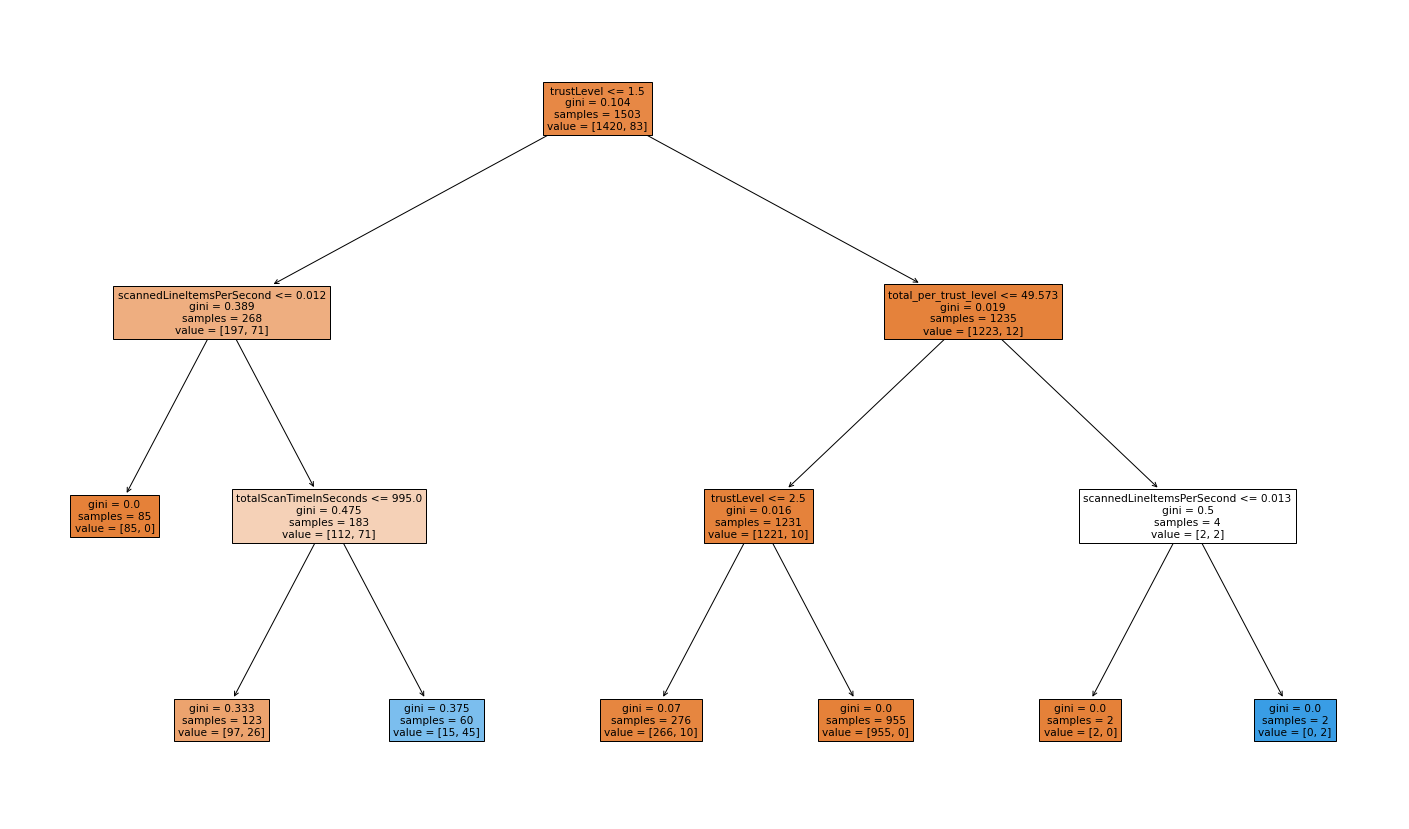

In [9]:
# defining input and target variables
X = train.drop(columns = ['fraud'], axis = 1)
Y = train['fraud']

# splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

# building decision tree model
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

# visualizing decision tree results
fig = plt.figure(figsize =(25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [16]:
# feature 5
train['interaction_5'] = np.where((train['trustLevel'] <= 1.5) & (train['total_per_trust_level'] <= 49.573) & (train['trustLevel'] <= 2.5), 1, 0)
test['interaction_5'] = np.where((test['trustLevel'] <= 1.5) & (test['total_per_trust_level'] <= 49.573) & (test['trustLevel'] <= 2.5), 1, 0)

In [17]:
# feature 6
train['interaction_quantity_voids'] = train['quantityModifications'] * train['lineItemVoids']
test['interaction_quantity_voids'] = test['quantityModifications'] * test['lineItemVoids']

In [18]:
# feature 7
train['interaction_value_voids'] = train['valuePerSecond'] * train['lineItemVoids']
test['interaction_value_voids'] = test['valuePerSecond'] * test['lineItemVoids']

In [19]:
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,total_per_trust_level,interaction_trust_voids,interaction_voids_without_registration,interaction_quantityM_Time,interaction_5,interaction_quantity_voids,interaction_value_voids
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,10.940,35,0,3162,0,21,0.363283
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,9.120,15,10,432,0,20,1.266667
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,20.720,9,30,7580,0,15,0.123008
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,15.385,48,32,7164,0,32,0.412328
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,16.306,15,21,860,0,6,0.568814


In [20]:
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,total_per_trust_level,interaction_trust_voids,interaction_voids_without_registration,interaction_quantityM_Time,interaction_5,interaction_quantity_voids,interaction_value_voids
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429,22.120000,16,32,1868,0,16,0.757859
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259,19.663333,21,42,1004,0,7,0.411285
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000,14.000000,4,20,648,1,16,0.345679
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857,16.958000,45,27,2128,0,36,1.434417
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526,8.432000,20,0,0,0,0,0.189483
